In [572]:
import importlib
import project_utils.deciles as deciles
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from general_utils import utils
from general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import os
from matplotlib import colors as mcolors
import math
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

utils.default_plot_format()
utils.pd_display_settings(3)

In [573]:
data_path = r"processed_data\raw_metrics\processed_10min_Nabian.pkl"

In [574]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()

#indicator_columns.remove('D2')
#non_linear_metrics.remove('D2')

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
3250,22212,22812,30.89,24.63,3.13,79.80,2.35e-08,0,1.61e-05,4.24e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3251,21611,22211,40.47,34.10,13.03,77.50,1.07e-08,0,9.96e-06,2.39e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3252,21010,21610,38.71,41.98,27.34,75.71,1.28e-09,0.00167,1.49e-06,3.11e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3253,34218,34818,88.51,31.71,12.61,79.37,1.33e-08,0.00167,1.59e-05,3.19e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3254,76304,76903,173.75,220.18,22.22,74.74,3.17e-09,0.00167,3.57e-06,1.2e-06,...,10.23,0.43,1,0,0,True,0,0,1,DPN


In [575]:
median_melted = deciles.produce_median_melt(data, indicator_columns)

metrics = ['HF Power', 'SDRR', 'SD2', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

metrics = time_metrics
#median_melted = median_melted[median_melted["metric"].isin(metrics)]


median_pivot = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()
print(median_pivot.columns)

Index(['id', 'DPN', 'ApEn', 'D2', 'DFA α1', 'DFA α2', 'HF Peak Frequency',
       'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio',
       'Mean HR (bpm)', 'RMSSD', 'S', 'SD1', 'SD1÷SD2', 'SD2', 'SDRR',
       'SampEn', 'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')


In [576]:

clusters = 3
 
kmeans = KMeans(n_clusters = clusters)
kmeans.fit(median_pivot)
 
print(list(kmeans.labels_))
dpn = median_pivot["DPN"]

dpn = list(1 if val else 0 for val in dpn)
print(dpn)




[0, 2, 0, 2, 2, 1, 2, 0, 1, 0, 2, 2, 2, 2, 0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


In [577]:

pca = PCA(3)
pca.fit(median_pivot)
 
pca_data = pd.DataFrame(pca.transform(median_pivot))
 
print(pca_data)

           0      1      2
0     703.28  21.71   4.03
1   -9300.75  21.22  -0.27
2    -748.30  16.44  -0.23
3  -11361.31  15.60 -10.03
4   -6864.78  19.56  -1.76
5      23034   7.65  10.39
6  -15419.58 -14.58  -7.40
7   -5285.82  12.76  12.02
8      24475  -4.97  -1.99
9   -4401.08  16.35 -10.55
10 -14359.11 -12.62  -1.48
11 -13385.26  -9.61   9.42
12 -15090.27  -9.68 -14.05
13  -9716.46  11.97 -10.76
14     10447  15.44 -35.24
15      5448   9.40  28.76
16     27939 -12.30   5.04
17  -8384.41   1.21   1.80
18   -543.70  10.04   7.11
19     35272 -21.24 -15.52
20      3578   4.01  11.78
21     29518 -14.94   0.21
22 -16571.13 -44.04   2.59
23   -935.96   1.11  17.98
24 -15990.00 -33.56   1.15
25 -12055.89  -6.92  -2.99


In [578]:
fig = go.Figure()

str_labels = [label for label in kmeans.labels_]
cluster_colors = {0: 'blue', 1: 'red'}
cluster_colors = dict(zip(range(clusters), cluster_colors.values()))

fig.add_trace(go.Scatter3d(
    x=pca_data[0],
    y=pca_data[1],
    z=pca_data[2],
    mode='markers+text',
    marker=dict(
        size=5,
        color=list(map(lambda label: cluster_colors[label], dpn)),
        opacity=0.8
    ),
    text=str_labels,
    textposition='top center'
))

fig.update_layout(
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3',
        aspectratio=dict(x=1, y=1, z=1),
        aspectmode='cube'
    ),
    width=600, height=500,
    margin=dict(l=10, r=10, b=10, t=10)
)

fig.show()


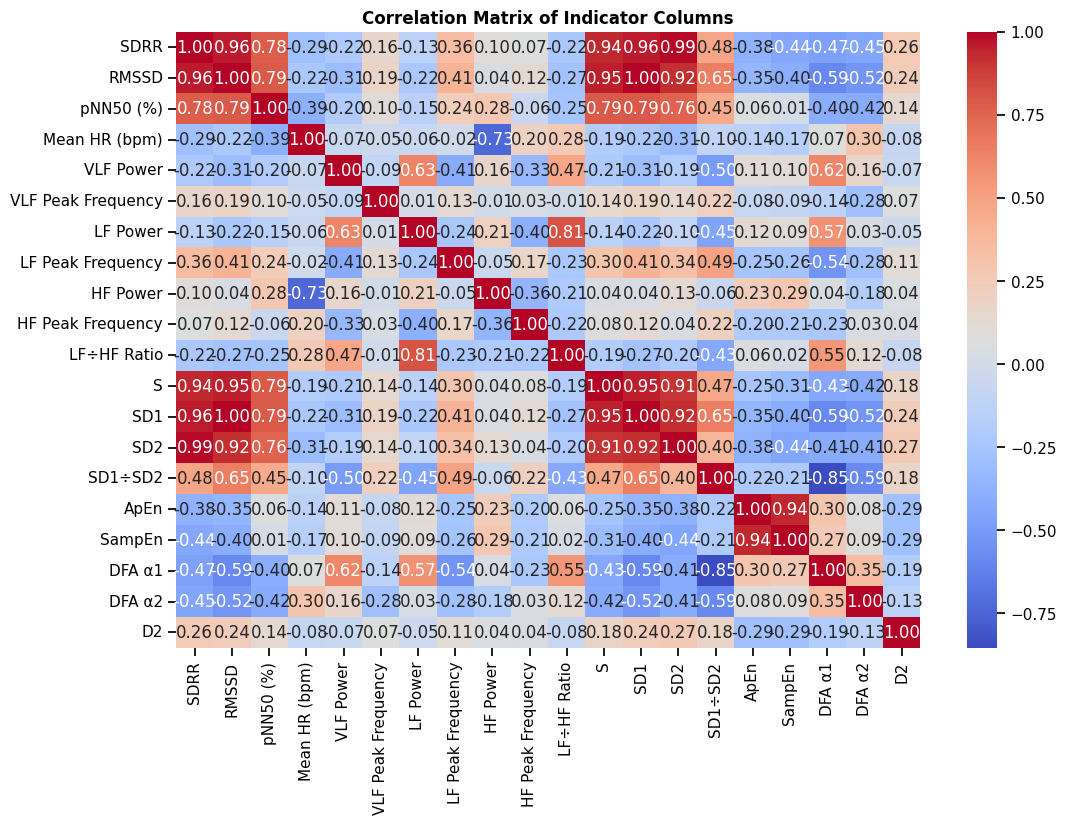

In [579]:
# Calculate the correlation matrix
correlation_matrix = data[indicator_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Indicator Columns')
plt.show()

# LDA

In [580]:
median_pivot.columns

Index(['id', 'DPN', 'ApEn', 'D2', 'DFA α1', 'DFA α2', 'HF Peak Frequency',
       'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio',
       'Mean HR (bpm)', 'RMSSD', 'S', 'SD1', 'SD1÷SD2', 'SD2', 'SDRR',
       'SampEn', 'VLF Peak Frequency', 'VLF Power', 'pNN50 (%)'],
      dtype='object', name='metric')

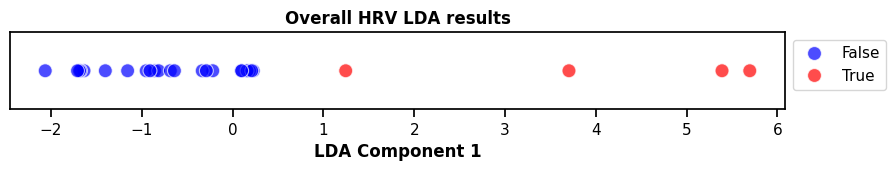

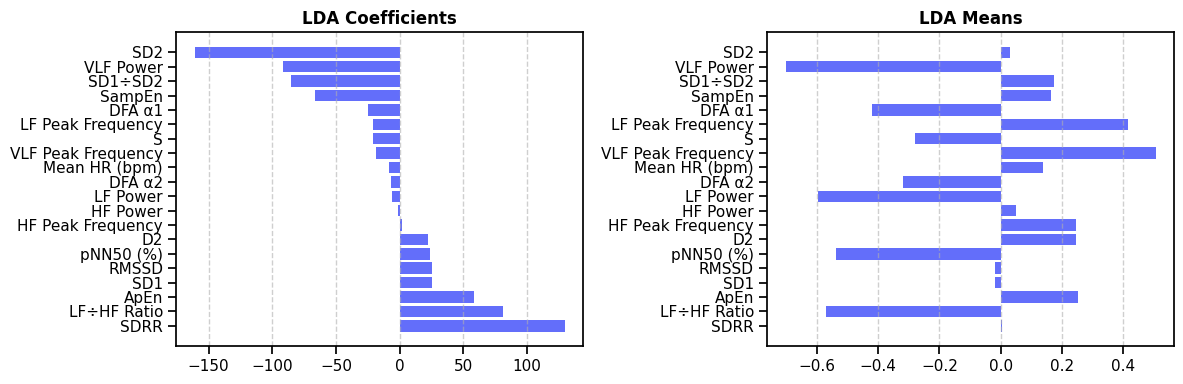

In [581]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import matplotlib.pyplot as plt

def perform_lda(data, columns = None, n_components=1):
    target = data["DPN"]
    if columns is not None:
        data = data[columns]

    data = 2 * (data - data.min()) / (data.max() - data.min()) - 1

    lda = LinearDiscriminantAnalysis(n_components=n_components)
    lda_data = lda.fit_transform(data, target)
    lda_df = pd.DataFrame(lda_data)
    lda_df['Cluster'] = target

   # print(dir(lda_data))
    return lda_df, lda


def plot_linear_lda(lda_df, title = 'LDA Results'):
    plt.figure(figsize=(10, 1))
    sns.scatterplot(x=lda_df[0], y=[0] * len(lda_df), hue=lda_df['Cluster'], palette=cluster_colors, s=100, alpha=0.7)
    plt.yticks([])
    plt.xlabel('LDA Component 1')
    plt.title(title)
    
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    plt.show()

def show_linear_lda_stats(lda, columns):
    #print("Explained variance ratio: ", lda.explained_variance_ratio_)
    #print("Intercept: ", lda.intercept_)
    #print("Priors", lda.priors_)

    df = pd.DataFrame({
        'Columns': columns,
        'LDA Coef': lda.coef_[0],
        'Means': lda.means_[0],
    })
    # Sort the DataFrame by coefficient values for better visualization
    df_sorted = df.sort_values(by='LDA Coef', ascending=False)

    # Plot the coefficients and means as horizontal bars
    plt.figure(figsize=(12, 4))

    # First subplot for LDA coefficients
    plt.subplot(1, 2, 1)
    plt.barh(df_sorted['Columns'], df_sorted['LDA Coef'])
    plt.title('LDA Coefficients')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Second subplot for means
    plt.subplot(1, 2, 2)
    plt.barh(df_sorted['Columns'], df_sorted['Means'])
    plt.title('LDA Means')
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()
   # display(df)
    return df




lda_df, lda = perform_lda(median_pivot, indicator_columns)
plot_linear_lda(lda_df, "Overall HRV LDA results")
df = show_linear_lda_stats(lda, indicator_columns)

In [582]:
from IPython.display import display
df_transposed = df.transpose()
df_transposed.columns = df_transposed.loc['Columns']
df_transposed = df_transposed.drop('Columns')
display(df_transposed)


Columns,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),VLF Power,VLF Peak Frequency,LF Power,LF Peak Frequency,HF Power,HF Peak Frequency,LF÷HF Ratio,S,SD1,SD2,SD1÷SD2,ApEn,SampEn,DFA α1,DFA α2,D2
LDA Coef,129.48,25.19,24.01,-8.19,-91.57,-18.46,-5.77,-21.10,-1.18,1.69,81.26,-20.82,25.27,-160.86,-85.57,58.55,-66.36,-24.67,-6.96,22.09
Means,0.00318,-0.0194,-0.54,0.14,-0.70,0.50,-0.60,0.42,0.0501,0.24,-0.57,-0.28,-0.0194,0.0286,0.17,0.25,0.16,-0.42,-0.32,0.25


LDA allows to isolate all of the DPN patients by over-fitting.

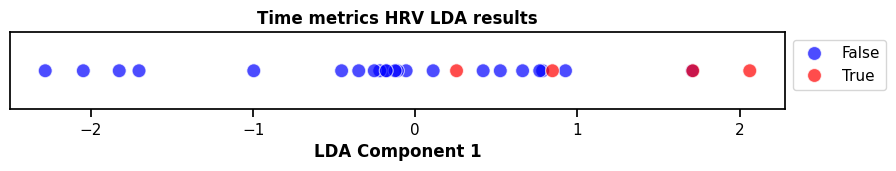

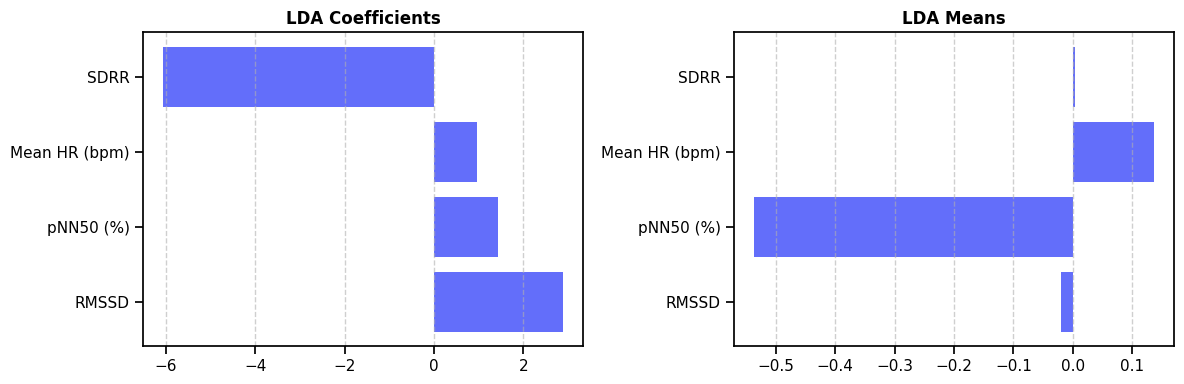

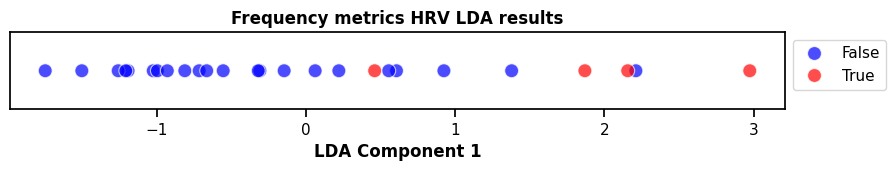

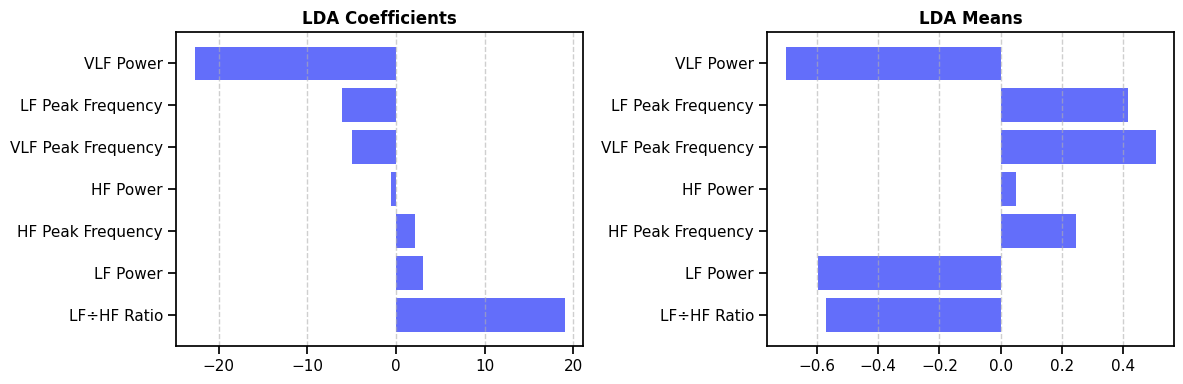

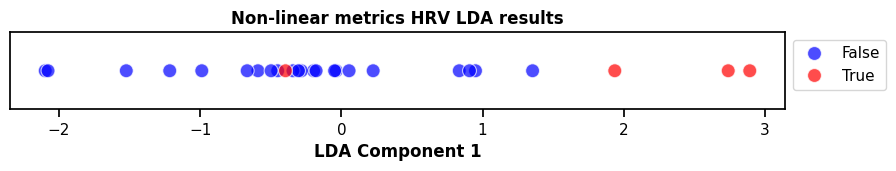

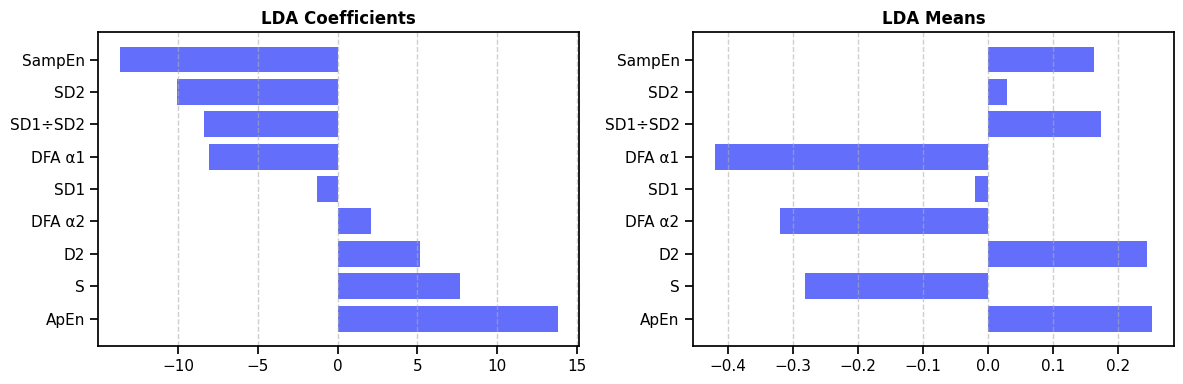

In [583]:
metric_lda = [] 
for col, name in zip([time_metrics, frequency_metrics, non_linear_metrics], ["Time", "Frequency", "Non-linear"]):
    lda_df, lda = perform_lda(median_pivot, col)
    plot_linear_lda(lda_df,  f"{name} metrics HRV LDA results")
    show_linear_lda_stats(lda, col)
    metric_lda.append([lda, lda_df, name])


In [584]:
full_df = pd.DataFrame()
for lda, lda_df, name in metric_lda:
    full_df[name] = lda_df[0]
    
full_df["cluster"] = metric_lda[0][1]["Cluster"]
display(full_df)

,Time,Frequency,Non-linear,cluster
0,-0.18,-1.19,-0.59,False
1,0.42,0.0601,-0.67,False
2,-0.0566,1.38,-0.45,False
3,-0.22,-0.31,-0.0363,False
4,-0.25,0.61,-0.20,False
5,-0.45,-1.03,-0.18,False
6,0.79,-0.56,0.95,False
7,0.11,0.55,0.84,False
8,-2.28,-1.75,0.0544,False
9,-1.00,-0.81,-1.52,False


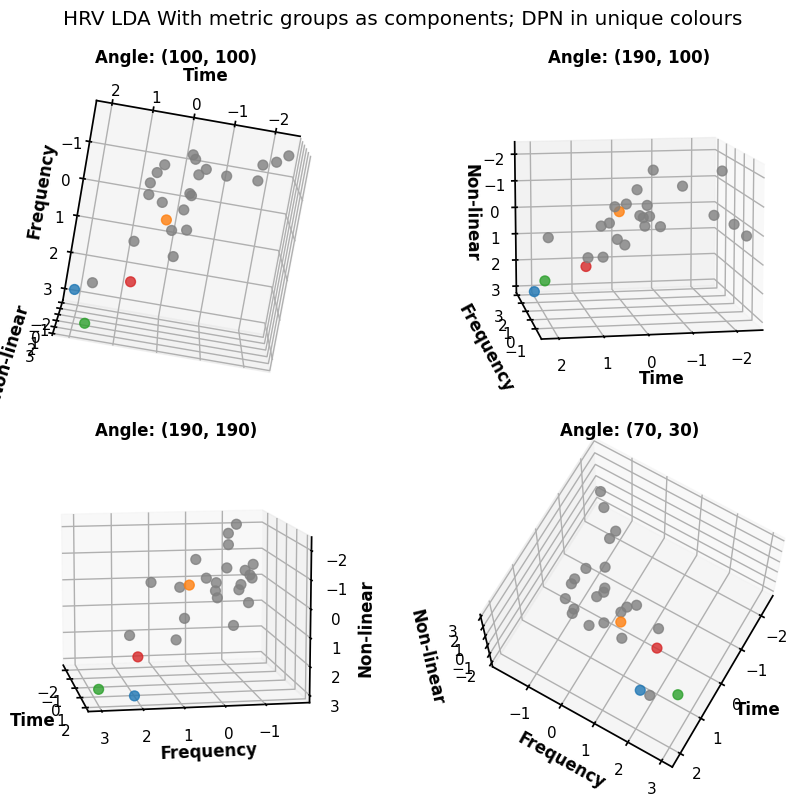

In [585]:
# Assign unique colors to each DPN patient
unique_dpn = full_df[full_df['cluster']].index
dpn_colors = {idx: color for idx, color in zip(unique_dpn, mcolors.TABLEAU_COLORS)}

fig = plt.figure(figsize=(10, 8))

# Define the angles for the subplots
angles = [(100, 100), (190, 100), (190, 190), (70, 30)]

fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, angle in enumerate(angles):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    ax.scatter(full_df['Time'], full_df['Frequency'], full_df['Non-linear'], 
               c=[dpn_colors[idx] if idx in dpn_colors else 'gray' for idx in full_df.index], 
               s=50, alpha=0.8)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Non-linear')
    ax.view_init(elev=angle[0], azim=angle[1])
    ax.set_title(f'Angle: {angle}')

plt.suptitle('HRV LDA With metric groups as components; DPN in unique colours')
plt.tight_layout()
plt.show()


### LDA Man whitney >0.10

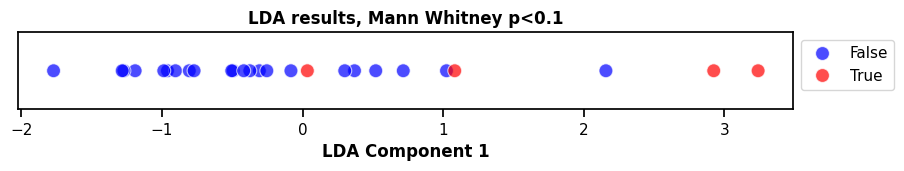

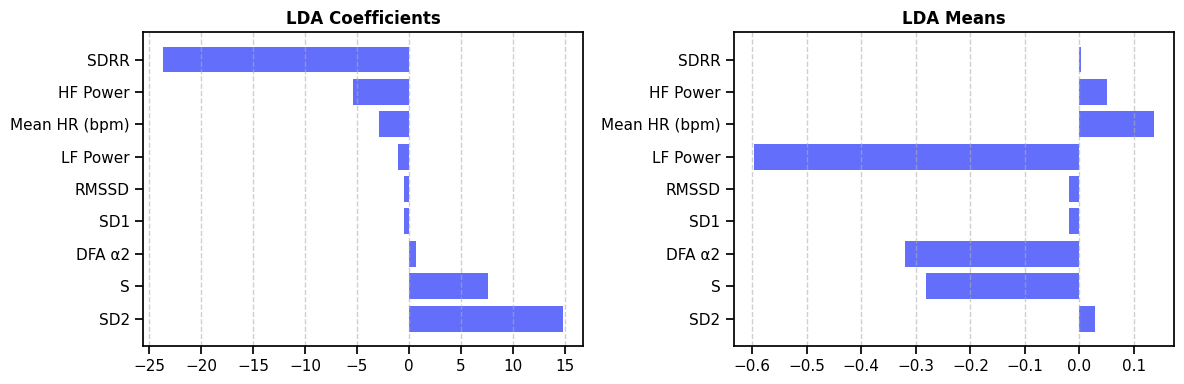

In [586]:
col = ['HF Power', 'SD2', 'SDRR', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

lda_df, lda = perform_lda(median_pivot, col)
plot_linear_lda(lda_df,  "LDA results, Mann Whitney p<0.1")
df = show_linear_lda_stats(lda, col)

# LDA permutations <0.1

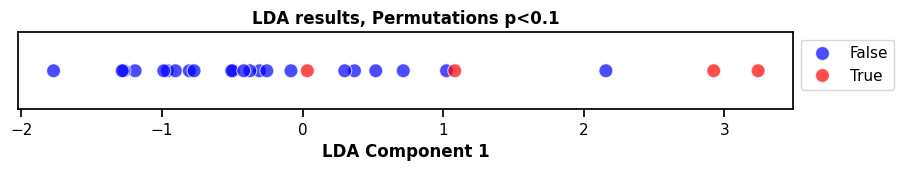

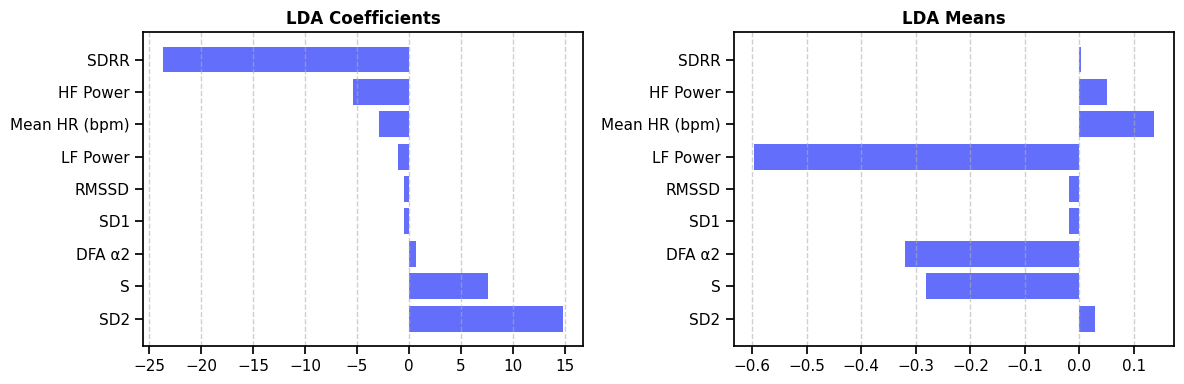

In [587]:
col = ['HF Power', 'SD2', 'SDRR', 'Mean HR (bpm)', 'LF Power', 'DFA α2', 'S',
       'RMSSD', 'SD1']

lda_df, lda = perform_lda(median_pivot, col)
plot_linear_lda(lda_df,  "LDA results, Permutations p<0.1")
df = show_linear_lda_stats(lda, col)

In [588]:
df_transposed = df.transpose()
df_transposed.columns = df_transposed.loc['Columns']
df_transposed = df_transposed.drop('Columns')
display(df_transposed)

Columns,HF Power,SD2,SDRR,Mean HR (bpm),LF Power,DFA α2,S,RMSSD,SD1
LDA Coef,-5.40,14.80,-23.68,-2.91,-1.06,0.62,7.57,-0.45,-0.45
Means,0.0501,0.0286,0.00318,0.14,-0.60,-0.32,-0.28,-0.0194,-0.0194


## LDA orthogonal metrics

In [589]:
# Calculate the absolute correlation matrix
import numpy as np

abs_corr_matrix = correlation_matrix.abs()

# Set the diagonal to a high value to exclude self-correlation
np.fill_diagonal(abs_corr_matrix.values, 1)

# Find the metrics with the lowest absolute correlation values
least_correlated_metrics = abs_corr_matrix.stack().nsmallest(15).index.tolist()
least_correlated_metrics = list(set([metric for pair in least_correlated_metrics for metric in pair]))

print("5 metrics that would correlate the least between each other:", least_correlated_metrics)

5 metrics that would correlate the least between each other: ['LF Peak Frequency', 'Mean HR (bpm)', 'SampEn', 'LF÷HF Ratio', 'LF Power', 'DFA α2', 'HF Peak Frequency', 'pNN50 (%)', 'VLF Peak Frequency', 'HF Power']


# Classifier and LDA

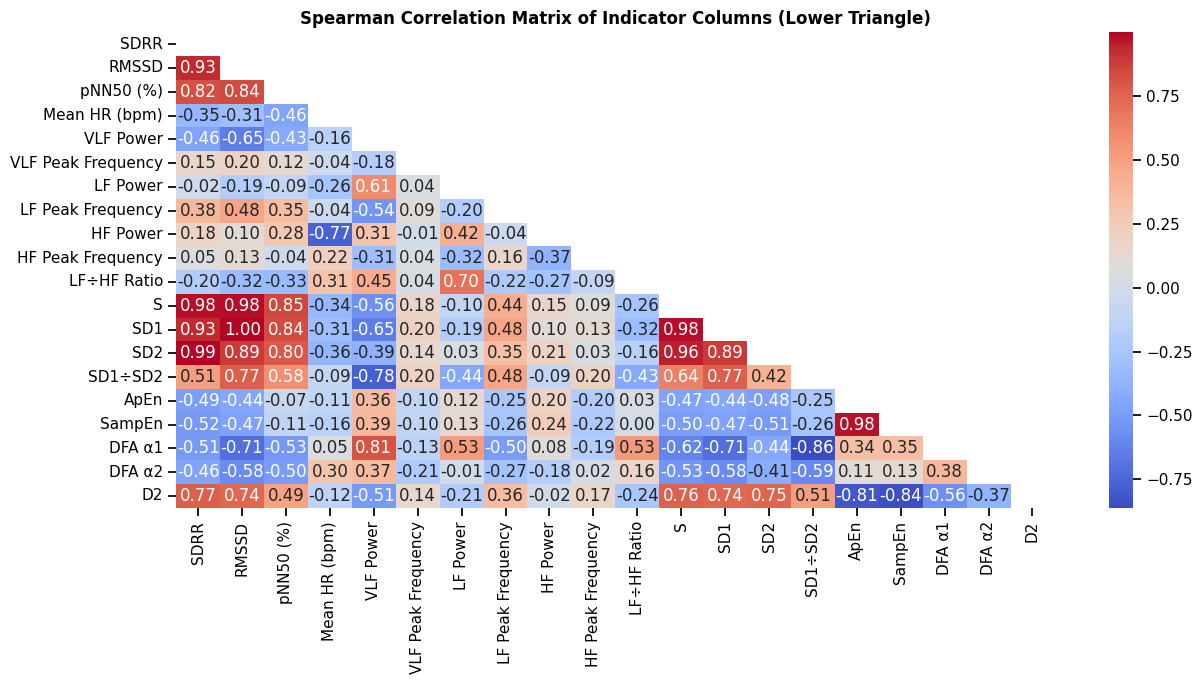

In [590]:
# Calculate the correlation matrix
correlation_matrix = data[indicator_columns].corr(method='spearman')

# Plot the heatmap
# Get the lower triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap with the mask
plt.figure(figsize=(13, 7))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Spearman Correlation Matrix of Indicator Columns (Lower Triangle)')
plt.tight_layout()
plt.show()

In [591]:
median = median_pivot
median = median[['id', 'DPN'] + indicator_columns]
median.columns

Index(['id', 'DPN', 'SDRR', 'RMSSD', 'pNN50 (%)', 'Mean HR (bpm)', 'VLF Power',
       'VLF Peak Frequency', 'LF Power', 'LF Peak Frequency', 'HF Power',
       'HF Peak Frequency', 'LF÷HF Ratio', 'S', 'SD1', 'SD2', 'SD1÷SD2',
       'ApEn', 'SampEn', 'DFA α1', 'DFA α2', 'D2'],
      dtype='object', name='metric')

In [592]:
def plot_vif(data:pd.DataFrame, height=5):
    nan_columns = data[data.isna().any(axis=1)]["feature"].tolist()
    melted_data = data.melt(id_vars=["feature"], value_vars=["Full VIF", "Excluded VIF"], var_name="VIF Type", value_name="VIF Value")
    plt.figure(figsize=(8, height))
   
    sns.barplot(x="VIF Value", y="feature", hue="VIF Type", data=melted_data, dodge=True)
    plt.title(f"VIF for wine variables; Excluded VIF for {nan_columns}")
    plt.legend()
    plt.xscale('log')
    plt.grid(axis='x', linestyle='-', alpha=0.5)
    plt.grid(axis='x', linestyle='--', which='minor',alpha = 0.5)
    plt.tight_layout()
    plt.show()

In [593]:
median.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  26 non-null     int64  
 1   DPN                 26 non-null     bool   
 2   SDRR                26 non-null     float64
 3   RMSSD               26 non-null     float64
 4   pNN50 (%)           26 non-null     float64
 5   Mean HR (bpm)       26 non-null     float64
 6   VLF Power           26 non-null     float64
 7   VLF Peak Frequency  26 non-null     float64
 8   LF Power            26 non-null     float64
 9   LF Peak Frequency   26 non-null     float64
 10  HF Power            26 non-null     float64
 11  HF Peak Frequency   26 non-null     float64
 12  LF÷HF Ratio         26 non-null     float64
 13  S                   26 non-null     float64
 14  SD1                 26 non-null     float64
 15  SD2                 26 non-null     float64
 16  SD1÷SD2   

In [594]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

def get_vif(data:pd.DataFrame, exclude_columns:list[str] = None) -> pd.DataFrame:
    vif_data = pd.DataFrame()

    # Store original columns
    original_columns = data.columns.tolist()
    
    vif_data["feature"] = original_columns
    vif_data["Full VIF"] = [variance_inflation_factor(data.values, i) for i in range(len(original_columns))]
    
    if exclude_columns is not None:
        if isinstance(exclude_columns, str):
            exclude_columns = [exclude_columns]
            
        # Create a filtered dataset without excluded columns
        filtered_data = data.drop(exclude_columns, axis=1)
        filtered_columns = filtered_data.columns.tolist()
        
        # Create mapping between original and filtered column indices
        filtered_vif_values = {}
        for i, col in enumerate(filtered_columns):
            filtered_vif_values[col] = variance_inflation_factor(filtered_data.values, i)
        
        # Build the Excluded VIF column, with NaN for excluded columns
        excluded_vif = []
        for col in original_columns:
            if col in filtered_columns:
                excluded_vif.append(filtered_vif_values[col])
            else:
                excluded_vif.append(np.nan)
                
        vif_data["Excluded VIF"] = excluded_vif
    # Sort by Excluded VIF if it exists, otherwise by Full VIF
    if "Excluded VIF" in vif_data.columns:
        vif_data = vif_data.sort_values(by="Excluded VIF", ascending=False, na_position='last')
    else:
        vif_data = vif_data.sort_values(by="Full VIF", ascending=False)
    return vif_data
    
    return vif_data
get_vif(median.drop(columns =['id', 'DPN']), ['SDRR', 'VLF Power'])

,feature,Full VIF,Excluded VIF
12,SD1,6923762851,6822932830
1,RMSSD,6923560612,6822746774
15,ApEn,4443,3760
16,SampEn,2924,2445
17,DFA α1,1221,1159
3,Mean HR (bpm),1293,967.65
5,VLF Peak Frequency,1335,517.26
14,SD1÷SD2,623.01,454.14
7,LF Peak Frequency,1176,440.81
18,DFA α2,516.75,435.18


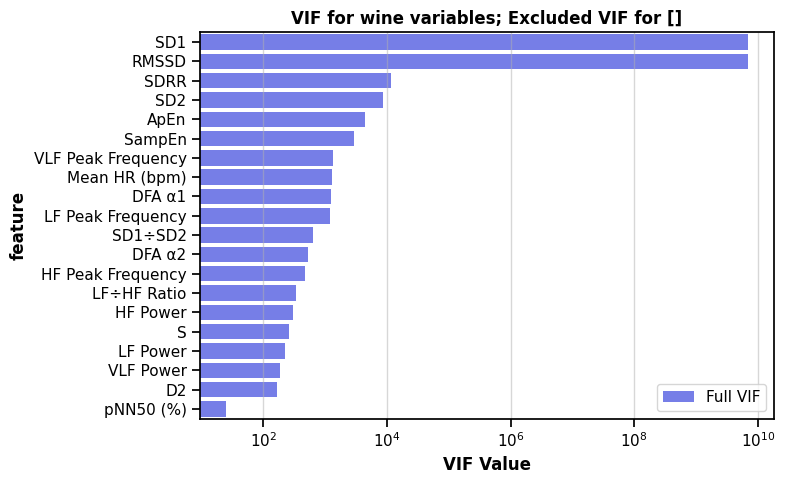

In [595]:
def plot_vif(data:pd.DataFrame, height=5):
    nan_columns = data[data.isna().any(axis=1)]["feature"].tolist()


    value_vars = ["Full VIF"] if "Excluded VIF" not in data.columns else ["Full VIF", "Excluded VIF"]
    melted_data = data.melt(id_vars=["feature"], value_vars=value_vars, var_name="VIF Type", value_name="VIF Value")
    plt.figure(figsize=(8, height))
   
    sns.barplot(x="VIF Value", y="feature", hue="VIF Type", data=melted_data, dodge=True)
    plt.title(f"VIF for wine variables; Excluded VIF for {nan_columns}")
    plt.legend()
    plt.xscale('log')
    plt.grid(axis='x', linestyle='-', alpha=0.5)
    plt.grid(axis='x', linestyle='--', which='minor',alpha = 0.5)
    plt.tight_layout()
    plt.show()

plot_vif(get_vif(median.drop(columns =['id', 'DPN'])))

In [596]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


def scale_data(data, equation_dict=median.drop(columns=['DPN']), extra_columns=[]):
    columns = list(equation_dict.keys())[1:]
    data = data.copy()[columns + ["DPN", *extra_columns]]
    scaler = StandardScaler()
    data[columns] = scaler.fit_transform(data[columns])
    data["DPN"] = data["DPN"].apply(lambda x: 0 if x <= 5 else 1)
    return data

scaled_train = scale_data(median.copy())

X_scaled = sm.add_constant(scaled_train.drop(columns=["DPN"]))

logit_model = sm.Logit(scaled_train["DPN"], X_scaled).fit()

         Current function value: 0.000000
         Iterations: 35


c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning:

Perfect separation or prediction detected, parameter may not be identified

c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: Per

Log classifier fails to converge, because a separation could not be identified.

## LDA feature isolation

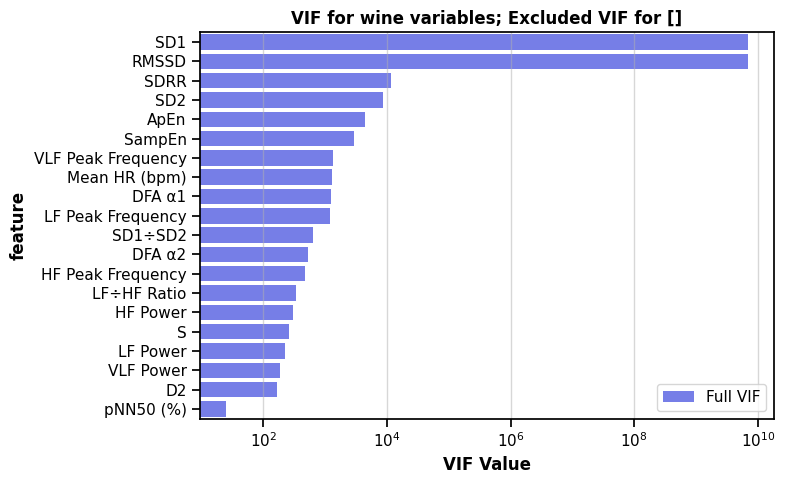

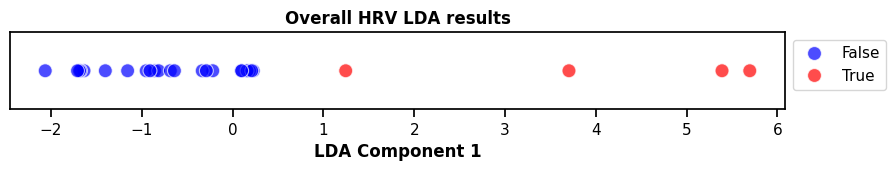

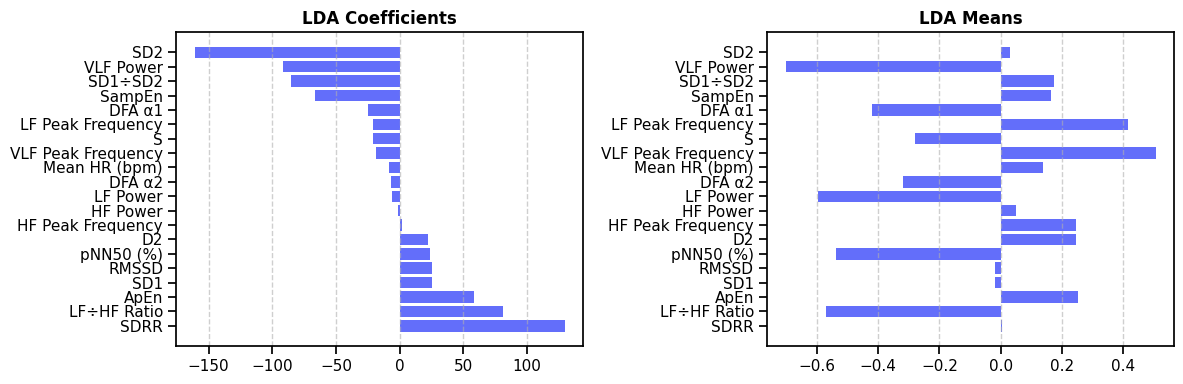

In [597]:
plot_vif(get_vif(median.drop(columns =['id', 'DPN'])))
lda_df, lda = perform_lda(median_pivot, indicator_columns)
plot_linear_lda(lda_df, "Overall HRV LDA results")
df = show_linear_lda_stats(lda, indicator_columns)


In [598]:

median.columns

Index(['id', 'DPN', 'SDRR', 'RMSSD', 'pNN50 (%)', 'Mean HR (bpm)', 'VLF Power',
       'VLF Peak Frequency', 'LF Power', 'LF Peak Frequency', 'HF Power',
       'HF Peak Frequency', 'LF÷HF Ratio', 'S', 'SD1', 'SD2', 'SD1÷SD2',
       'ApEn', 'SampEn', 'DFA α1', 'DFA α2', 'D2'],
      dtype='object', name='metric')

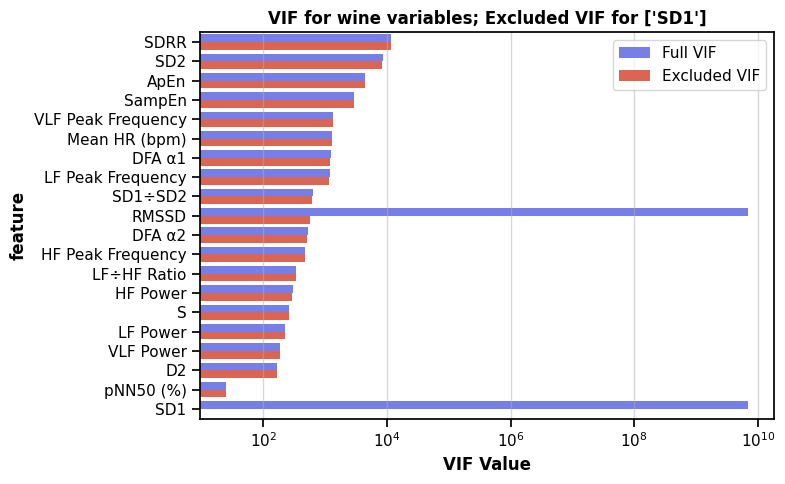

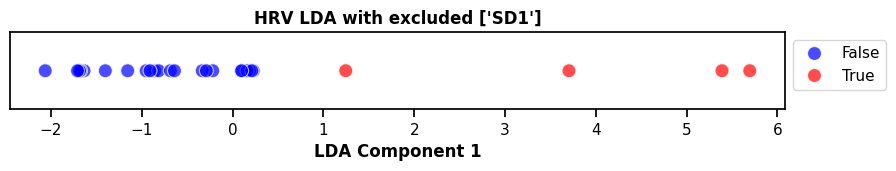

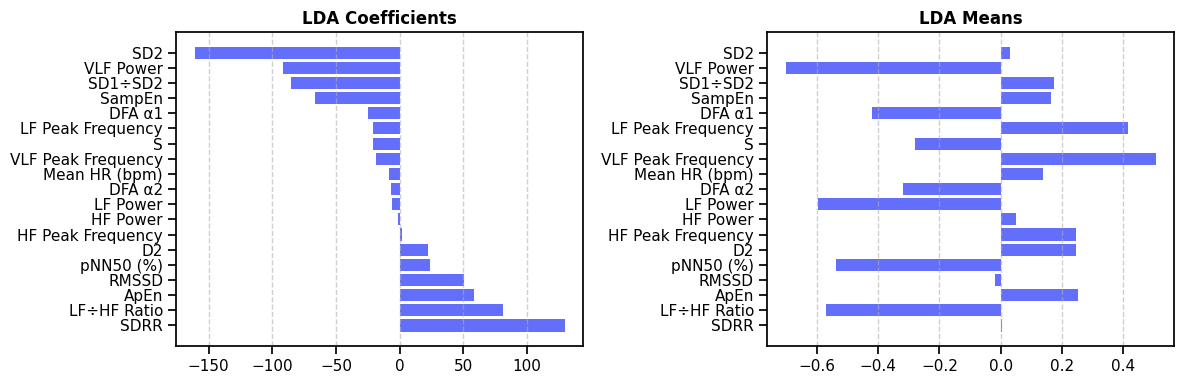

In [599]:
def lda_vif_exclude(data, exclude):
    data = data.copy()
    if isinstance(exclude, str):
        exclude = [exclude]

    plot_vif(get_vif(data.drop(columns =['id', 'DPN']), exclude_columns=exclude))
    data = data.drop(columns=exclude)
    indicator_columns = data.columns[2:]
    lda_df, lda = perform_lda(data, indicator_columns)
    plot_linear_lda(lda_df, f"HRV LDA with excluded {exclude}")
    show_linear_lda_stats(lda, indicator_columns)

lda_vif_exclude(median, 'SD1')
median = median.drop(columns ='SD1')


SD can be very easily excluded

In [600]:
median.columns

Index(['id', 'DPN', 'SDRR', 'RMSSD', 'pNN50 (%)', 'Mean HR (bpm)', 'VLF Power',
       'VLF Peak Frequency', 'LF Power', 'LF Peak Frequency', 'HF Power',
       'HF Peak Frequency', 'LF÷HF Ratio', 'S', 'SD2', 'SD1÷SD2', 'ApEn',
       'SampEn', 'DFA α1', 'DFA α2', 'D2'],
      dtype='object', name='metric')

index.columns

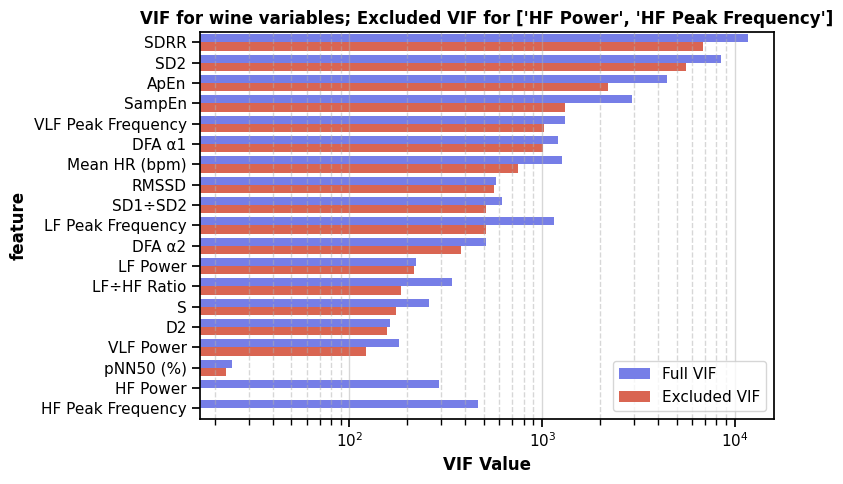

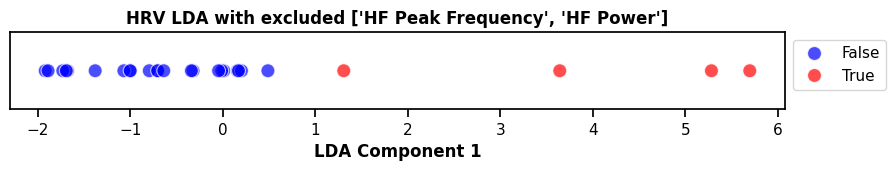

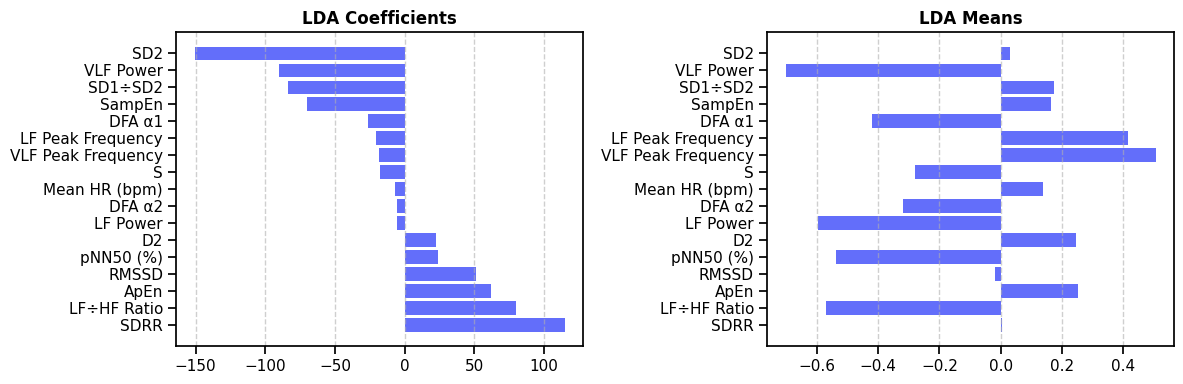

In [ ]:
lda_vif_exclude(median, ['HF Peak Frequency', 'HF Power'])
median = median.drop(columns =['HF Peak Frequency', 'HF Power'])
break

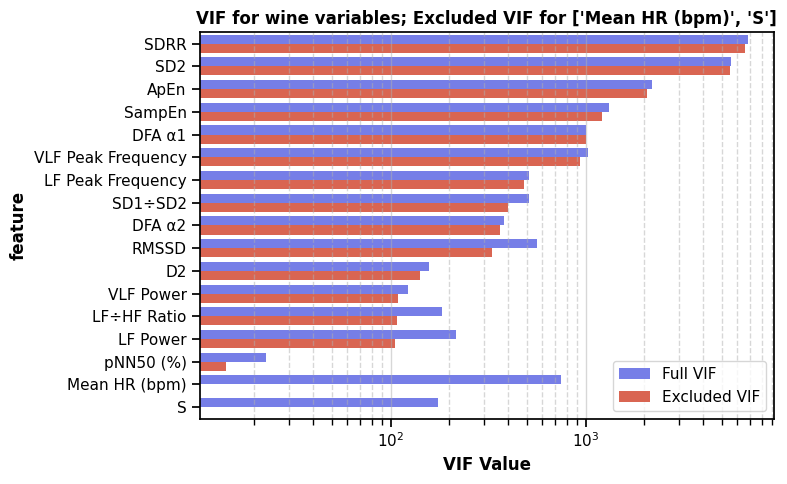

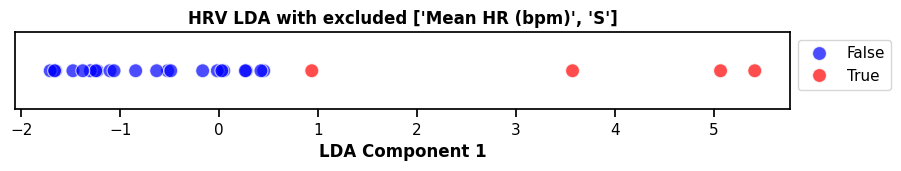

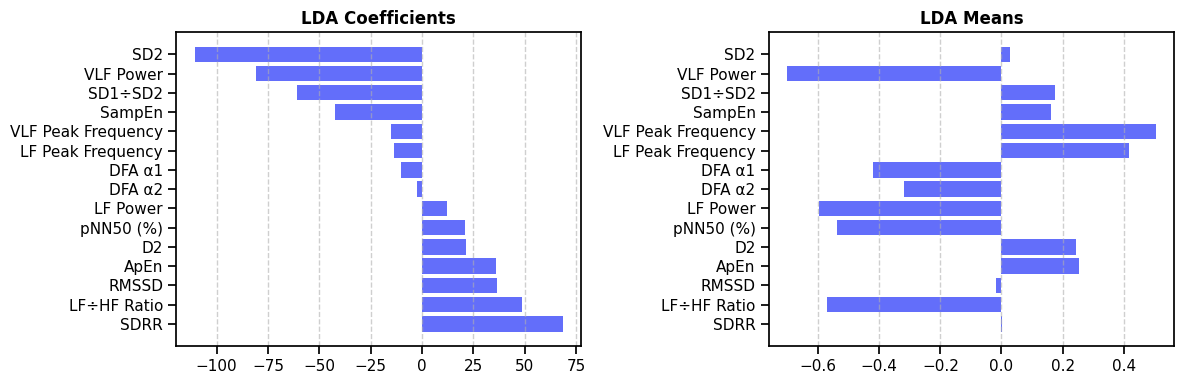

SyntaxError: 'break' outside loop (3555044285.py, line 3)

In [ ]:
lda_vif_exclude(median, ['Mean HR (bpm)', 'S'])
median = median.drop(columns =['Mean HR (bpm)', 'S'])
break

SD2 is too important for separation to drop

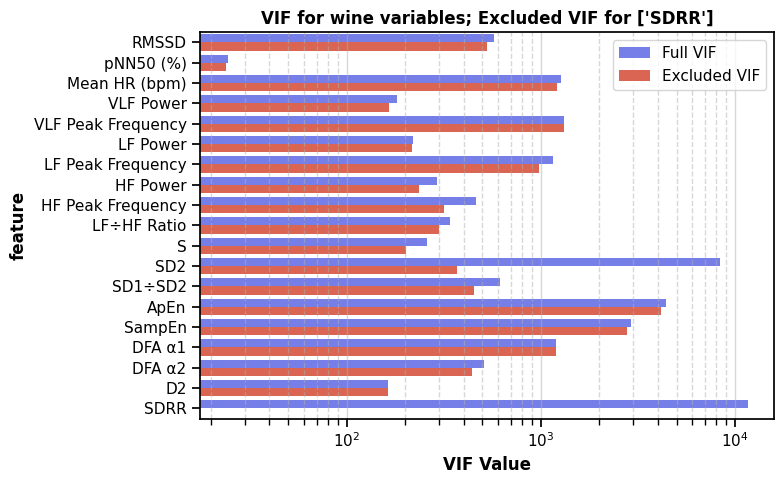

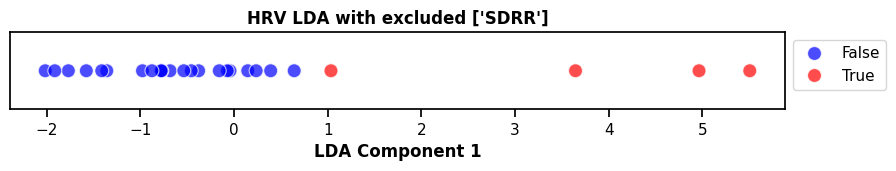

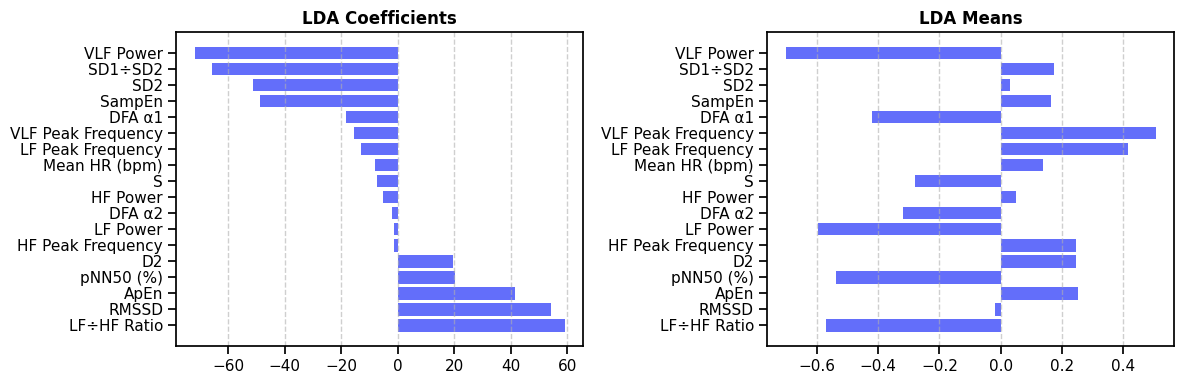

SyntaxError: 'break' outside loop (405996224.py, line 4)

In [ ]:
lda_vif_exclude(median, 'SDRR')
median = median.drop(columns ='SDRR')
##SDRR is quite important, but can be dropped
break

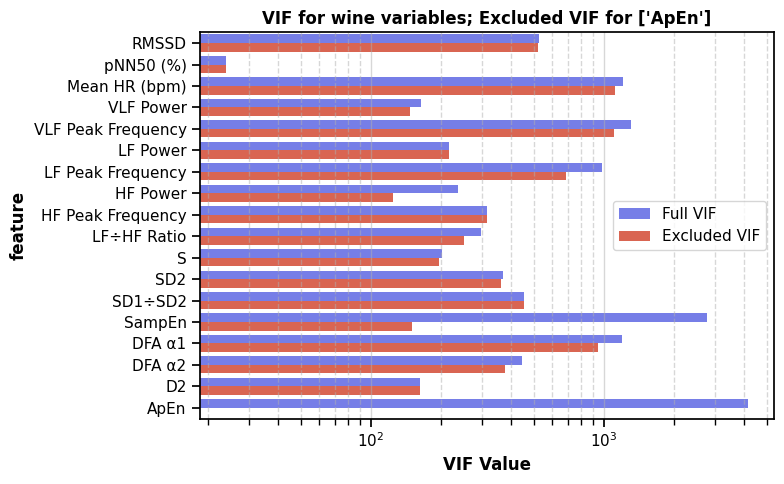

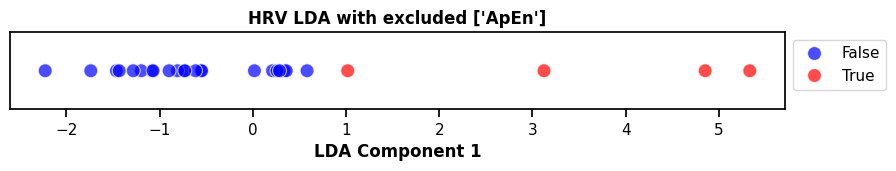

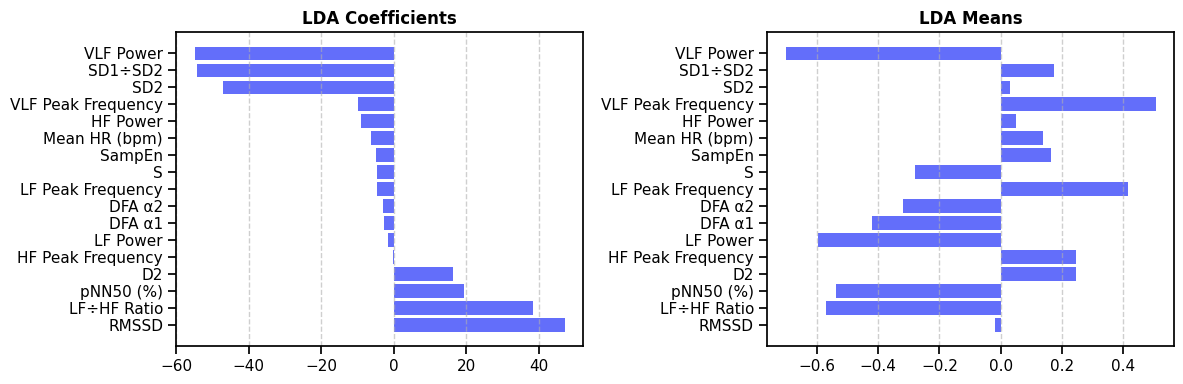

In [ ]:
lda_vif_exclude(median, 'ApEn')
median = median.drop(columns ='ApEn')

Apen has no result

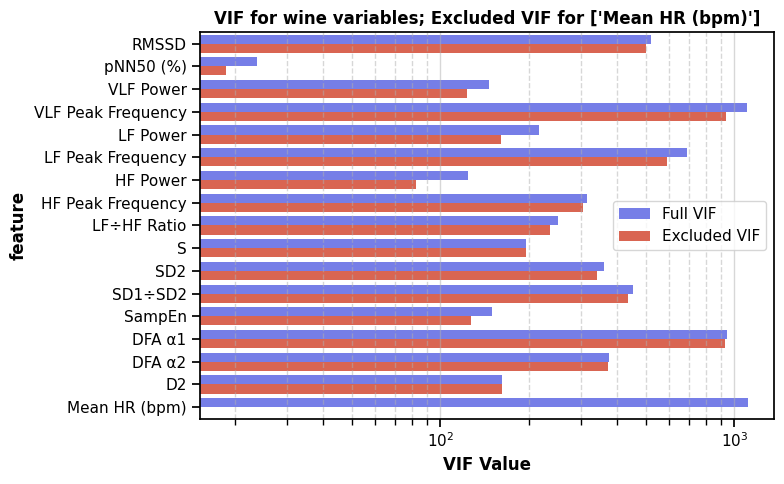

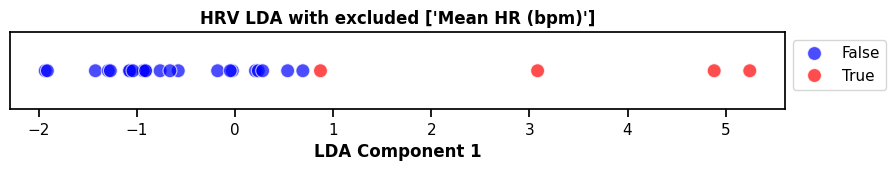

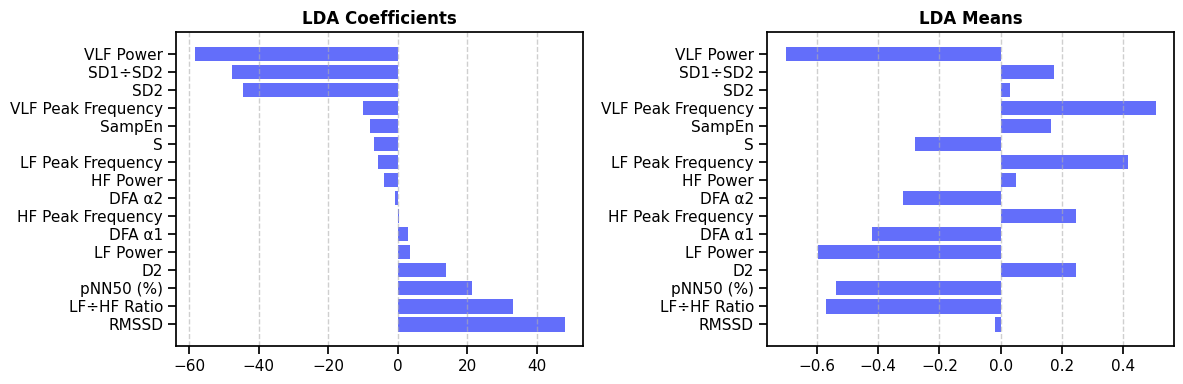

In [ ]:
lda_vif_exclude(median, 'Mean HR (bpm)')
median = median.drop(columns ='Mean HR (bpm)')

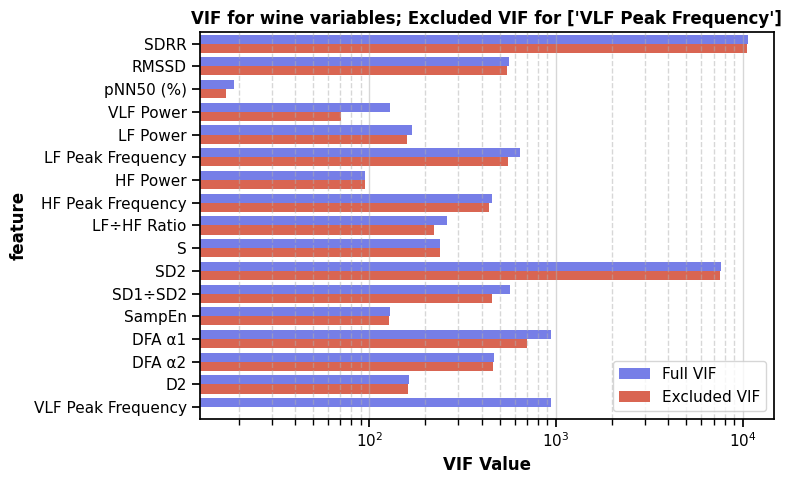

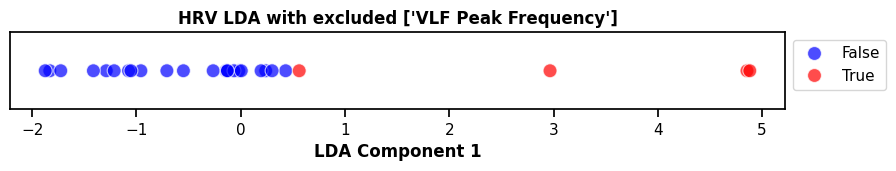

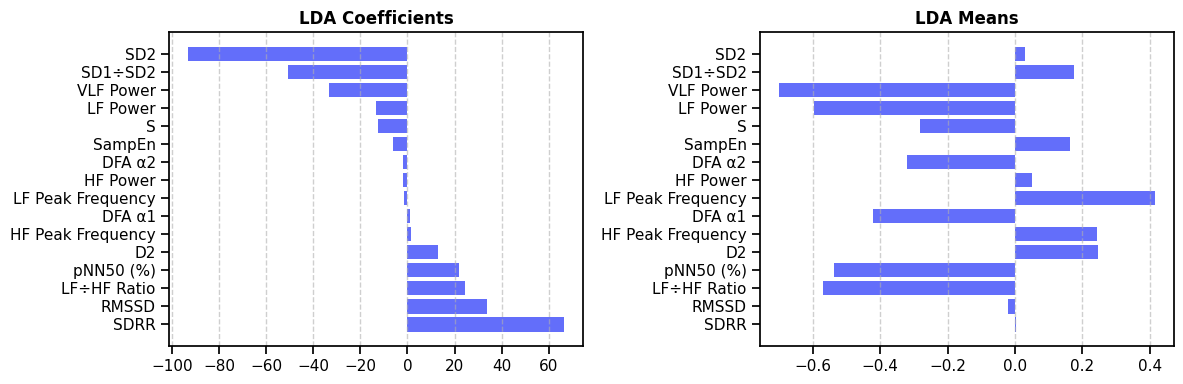

In [ ]:
lda_vif_exclude(median, 'VLF Peak Frequency')
median = median.drop(columns ='VLF Peak Frequency')

In [ ]:
median.columns

Index(['id', 'DPN', 'SDRR', 'RMSSD', 'pNN50 (%)', 'VLF Power', 'LF Power',
       'LF Peak Frequency', 'HF Power', 'HF Peak Frequency', 'LF÷HF Ratio',
       'S', 'SD2', 'SD1÷SD2', 'SampEn', 'DFA α1', 'DFA α2', 'D2'],
      dtype='object', name='metric')

In [ ]:
lda_vif_exclude(median, 'VLF Peak Frequency')
median = median.drop(columns ='VLF Peak Frequency')

KeyError: "['VLF Peak Frequency'] not in index"